> # Music Genre and Composer Classification Using Deep Learning
 ![Music Genre and Composer Classification Using Deep Learning](data/header.png)
 

**University of San Diego**
AAI-511: Neural Networks and Deep Learning

---
**Professor**: Rod Albuyeh
**Section**: 5  
**Group**: 2  
**Contributors**:
- Ashley Moore
- Kevin Pooler
- Swapnil Patil


August, 2025

---

<a id='Index'></a>
# Index

1. [Introduction](#introduction)
1. [Objective](#objective)
1. [Dataset](#dataset)
1. [Data Cleaning and Preprocessing](#datacleaning)
1. [Feature Extraction](#featureextraction)
1. [Exploratory Data Analysis](#exploratory)
1. [Model Building](#modelbuilding):
    - [LSTM](#modelbuildinglstm)    
    - [CNN](#modelbuildingcnn)
1. [Model Training](#modeltraining)
1. [Model Evaluation](#modelevaluation)
1. [Model Optimization](#modeloptimization)
1. [Deployment](#deployment)
1. [Conclusion](#conclusion)
1. [Recommendations](#recommendations)
1. [Next Steps](#nextsteps)
1. [References](#references)

### Streamlit Application
[Application URL](https://musicai.streamlit.app/)

<a id='introduction'></a>
# 1. Introduction: <a href="#Index" style="font-size:25px;">&#8679;</a>

---

Music is a form of art that is ubiquitous and has a rich history. Different composers have created music with their unique styles and compositions. However, identifying the composer of a particular piece of music can be a challenging task, especially for novice musicians or listeners. The proposed project aims to use deep learning techniques to identify the composer of a given piece of music accurately.

<a id='objective'></a>
# 2. Objective: <a href="#Index" style="font-size:25px;">&#8679;</a>
---

#### Problem Statement

The primary objective of this project is to develop a deep learning model that can predict the composer of a given musical score accurately. The project aims to accomplish this objective by using two deep learning techniques: Long Short-Term Memory (LSTM) and Convolutional Neural Network (CNN).

<a id='dataset'></a>
# 3. Dataset:
---

The project will use a dataset consisting of musical scores from various composers.

https://www.kaggle.com/datasets/blanderbuss/midi-classic-music

The dataset contains the midi files of compositions from well-known classical composers like Bach, Beethoven, Chopin, and Mozart. The dataset should be labeled with the name of the composer for each score. Please only do your prediction only for below composers, therefore you need to select the required composers from the given dataset above.

1. Bach
1. Beethoven
1. Chopin
1. Mozart

<a id='datacleaning'></a>
# 4. Data Cleaning and Pre-processing: <a href="#Index" style="font-size:25px;">&#8679;</a>
---

In [1]:
%pip install -r requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: numpy>=1.21.0 in d:\personal\ai-admissions\semester 3\aai-511 - neural networks and deep learning\final team project\aai_511_2proj\.venv\lib\site-packages (from -r requirements.txt (line 1)) (2.1.3)




[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Import necessary libraries
import sys
import os
import shutil
import joblib
import hashlib
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from concurrent.futures import ThreadPoolExecutor, as_completed

# Music processing libraries
import pypianoroll
import music21
import pretty_midi
import librosa
import librosa.display
from music21 import converter, midi, tempo, key, instrument, note, chord, stream
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Embedding, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

sys.path.append(os.path.abspath(os.path.join(os.pardir, 'src')))

np.random.seed(42)
tf.random.set_seed(42)
sns.set(style='whitegrid')
warnings.filterwarnings("ignore")
plt.style.use('default')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [3]:
data_dir = "data/midiclassics"
target_composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

In [4]:
class MidiProcessor:

    def load_midi_files(self, data_dir, max_files_per_composer=None, n_jobs=8):
        all_files = []
        composers = [c for c in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, c))]
        def process_composer(composer):
            composer_path = os.path.join(data_dir, composer)
            midi_files = [f for f in os.listdir(composer_path) if f.endswith('.mid')]
            if max_files_per_composer:
                midi_files = midi_files[:max_files_per_composer]
            return [
                {
                    'file_path': os.path.join(composer_path, midi_file),
                    'composer': composer,
                    'filename': midi_file
                }
                for midi_file in midi_files
            ]
        with ThreadPoolExecutor(max_workers=n_jobs) as executor:
            futures = [executor.submit(process_composer, composer) for composer in composers]
            for f in as_completed(futures):
                all_files.extend(f.result())
        return pd.DataFrame(all_files)

    @staticmethod
    def extract_notes_from_midi(midi_path, max_notes=500):
        try:
            midi = converter.parse(midi_path)
            notes_to_parse = []
            if hasattr(midi, 'parts'):
                for part in midi.parts:
                    notes_to_parse.extend(part.recurse().notes)
            else:
                notes_to_parse = midi.flat.notes
            notes = []
            for element in notes_to_parse:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))
            if len(notes) > max_notes:
                notes = notes[:max_notes]
            return notes
        except Exception as e:
            print(f"Error processing {midi_path}: {str(e)}")
            return []

    @staticmethod
    def extract_notes_from_midi_parallel(midi_paths, max_notes=500, n_jobs=8):
        results = [None] * len(midi_paths)
        def worker(idx, midi_path):
            results[idx] = MidiProcessor.extract_notes_from_midi(midi_path, max_notes)
        with ThreadPoolExecutor(max_workers=n_jobs) as executor:
            futures = [executor.submit(worker, idx, path) for idx, path in enumerate(midi_paths)]
            for _ in as_completed(futures):
                pass
        return results

    @staticmethod
    def extract_musical_features(midi_path):
        try:
            midi = converter.parse(midi_path)
            features = {}
            features['total_notes'] = len(midi.flat.notes)
            features['total_duration'] = float(midi.duration.quarterLength) if midi.duration else 0

            # Time signature
            time_sigs = midi.getTimeSignatures()
            if time_sigs:
                features['time_signature'] = f"{time_sigs[0].numerator}/{time_sigs[0].denominator}"
            else:
                features['time_signature'] = "4/4"

            # Key
            key_sigs = midi.analyze('key')
            features['key'] = str(key_sigs) if key_sigs else "C major"
            if hasattr(key_sigs, 'correlationCoefficient'):
                features['key_confidence'] = float(abs(key_sigs.correlationCoefficient))
            else:
                features['key_confidence'] = None

            # Tempo
            tempo_markings = midi.flat.getElementsByClass('MetronomeMark')
            if tempo_markings:
                features['tempo'] = float(tempo_markings[0].number)
            else:
                features['tempo'] = 120.0

            # Pitch features
            pitches = [n.pitch.midi for n in midi.flat.notes if isinstance(n, note.Note)]
            if pitches:
                features['avg_pitch'] = np.mean(pitches)
                features['pitch_range'] = max(pitches) - min(pitches)
                features['pitch_std'] = np.std(pitches)
            else:
                features['avg_pitch'] = 60
                features['pitch_range'] = 0
                features['pitch_std'] = 0

            # Duration features
            durations = [float(n.duration.quarterLength) for n in midi.flat.notes if n.duration]
            if durations:
                features['avg_duration'] = np.mean(durations)
                features['duration_std'] = np.std(durations)
            else:
                features['avg_duration'] = 1.0
                features['duration_std'] = 0

            # Interval features
            intervals = []
            prev_pitch = None
            for n in midi.flat.notes:
                if isinstance(n, note.Note):
                    if prev_pitch is not None:
                        intervals.append(abs(n.pitch.midi - prev_pitch))
                    prev_pitch = n.pitch.midi
            if intervals:
                features['avg_interval'] = np.mean(intervals)
                features['interval_std'] = np.std(intervals)
            else:
                features['avg_interval'] = 0
                features['interval_std'] = 0

            # Instrumentation
            instruments_list = []
            for part in midi.parts:
                instr = part.getInstrument(returnDefault=True)
                instruments_list.append(str(instr))
            features['instruments'] = list(set(instruments_list))

            # Number of parts/tracks
            features['num_parts'] = len(midi.parts)

            # Measure and beat features
            measures = list(midi.parts[0].getElementsByClass('Measure')) if midi.parts else []
            features['num_measures'] = len(measures)
            features['avg_notes_per_measure'] = features['total_notes'] / len(measures) if measures else 0

            # Chord features
            chords = [el for el in midi.flat.notesAndRests if isinstance(el, chord.Chord)]
            features['num_chords'] = len(chords)
            features['chord_types'] = list(set([c.commonName for c in chords])) if chords else []

            # Rest features
            rests = [el for el in midi.flat.notesAndRests if isinstance(el, note.Rest)]
            features['num_rests'] = len(rests)
            features['rest_ratio'] = len(rests) / features['total_notes'] if features['total_notes'] > 0 else 0

            return features
        except Exception as e:
            print(f"Error extracting features from {midi_path}: {str(e)}")
            return {}

    @staticmethod
    def extract_musical_features_parallel(midi_paths, n_jobs=8):
        results = [None] * len(midi_paths)
        def worker(idx, midi_path):
            results[idx] = MidiProcessor.extract_musical_features(midi_path)
        with ThreadPoolExecutor(max_workers=n_jobs) as executor:
            futures = [executor.submit(worker, idx, path) for idx, path in enumerate(midi_paths)]
            for _ in as_completed(futures):
                pass
        return results

    @staticmethod
    def create_note_sequences(notes_list, sequence_length=100):
        sequences = []
        all_notes = []
        for notes in notes_list:
            all_notes.extend(notes)
        unique_notes = sorted(set(all_notes))
        note_to_int = {note: i for i, note in enumerate(unique_notes)}
        for notes in notes_list:
            if len(notes) >= sequence_length:
                note_ints = [note_to_int[note] for note in notes if note in note_to_int]
                for i in range(len(note_ints) - sequence_length + 1):
                    sequences.append(note_ints[i:i + sequence_length])
        return np.array(sequences), note_to_int, unique_notes

    @staticmethod
    def preprocess_midi_files(file_df, min_duration=5.0, min_key_confidence=0.7, verbose=True, n_jobs=8):
        processed_files = []
        seen_hashes = set()
        total = len(file_df)
        stats = {
            'total': total,
            'corrupted': 0,
            'zero_length': 0,
            'duplicates': 0,
            'too_short': 0,
            'ambiguous_key': 0,
            'kept': 0
        }

        def process_row(idx_row):
            idx, row = idx_row
            path = row['file_path']
            try:
                mf = midi.MidiFile()
                mf.open(path)
                mf.read()
                mf.close()
                if len(mf.tracks) == 0 or mf.ticksPerQuarterNote == 0:
                    return ('zero_length', None)
                with open(path, 'rb') as f:
                    file_hash = hashlib.md5(f.read()).hexdigest()
                # Deduplication will be handled after parallel processing
                score = converter.parse(path)
                duration = score.duration.seconds if score.duration else 0
                if duration < min_duration:
                    return ('too_short', None)
                tempos = list(score.flat.getElementsByClass(tempo.MetronomeMark))
                if tempos:
                    effective_bpm = float(np.median([t.number for t in tempos if t.number]))
                else:
                    effective_bpm = 120.0
                for t in tempos:
                    score.remove(t)
                score.insert(0, tempo.MetronomeMark(number=effective_bpm))
                key_obj = score.analyze('key')
                if hasattr(key_obj, 'correlationCoefficient'):
                    confidence = abs(key_obj.correlationCoefficient)
                else:
                    confidence = 1.0
                if confidence < min_key_confidence:
                    return ('ambiguous_key', None)
                parts = score.parts.stream()
                if len(parts) > 1:
                    score = parts[0]
                return ('kept', (file_hash, row))
            except Exception as e:
                return ('corrupted', None)

        completed = 0
        with ThreadPoolExecutor(max_workers=n_jobs) as executor:
            futures = [executor.submit(process_row, (idx, row)) for idx, row in file_df.iterrows()]
            for f in as_completed(futures):
                result, data = f.result()
                completed += 1
                percent = (completed / total) * 100
                if verbose:
                    print(f"\rProcessing: {completed}/{total} ({percent:.1f}%)", end='', flush=True)
                if result == 'kept' and data:
                    file_hash, row = data
                    if file_hash in seen_hashes:
                        stats['duplicates'] += 1
                        continue
                    seen_hashes.add(file_hash)
                    processed_files.append(row)
                    stats['kept'] += 1
                else:
                    stats[result] += 1
        if verbose:
            print()  # Move to next line after progress bar
            print("Preprocessing MIDI files:")
            print(f"Total files: {stats['total']}")
            print(f"Corrupted files: {stats['corrupted']}")
            print(f"Zero-length files: {stats['zero_length']}")
            print(f"Duplicates: {stats['duplicates']}")
            print(f"Too short (<{min_duration}s): {stats['too_short']}")
            print(f"Ambiguous key: {stats['ambiguous_key']}")
            print(f"Kept: {stats['kept']}")

        return pd.DataFrame(processed_files)

Total MIDI files found: 1785
Filtered MIDI files for target composers (4): 481
Valid MIDI files after preprocessing: 481


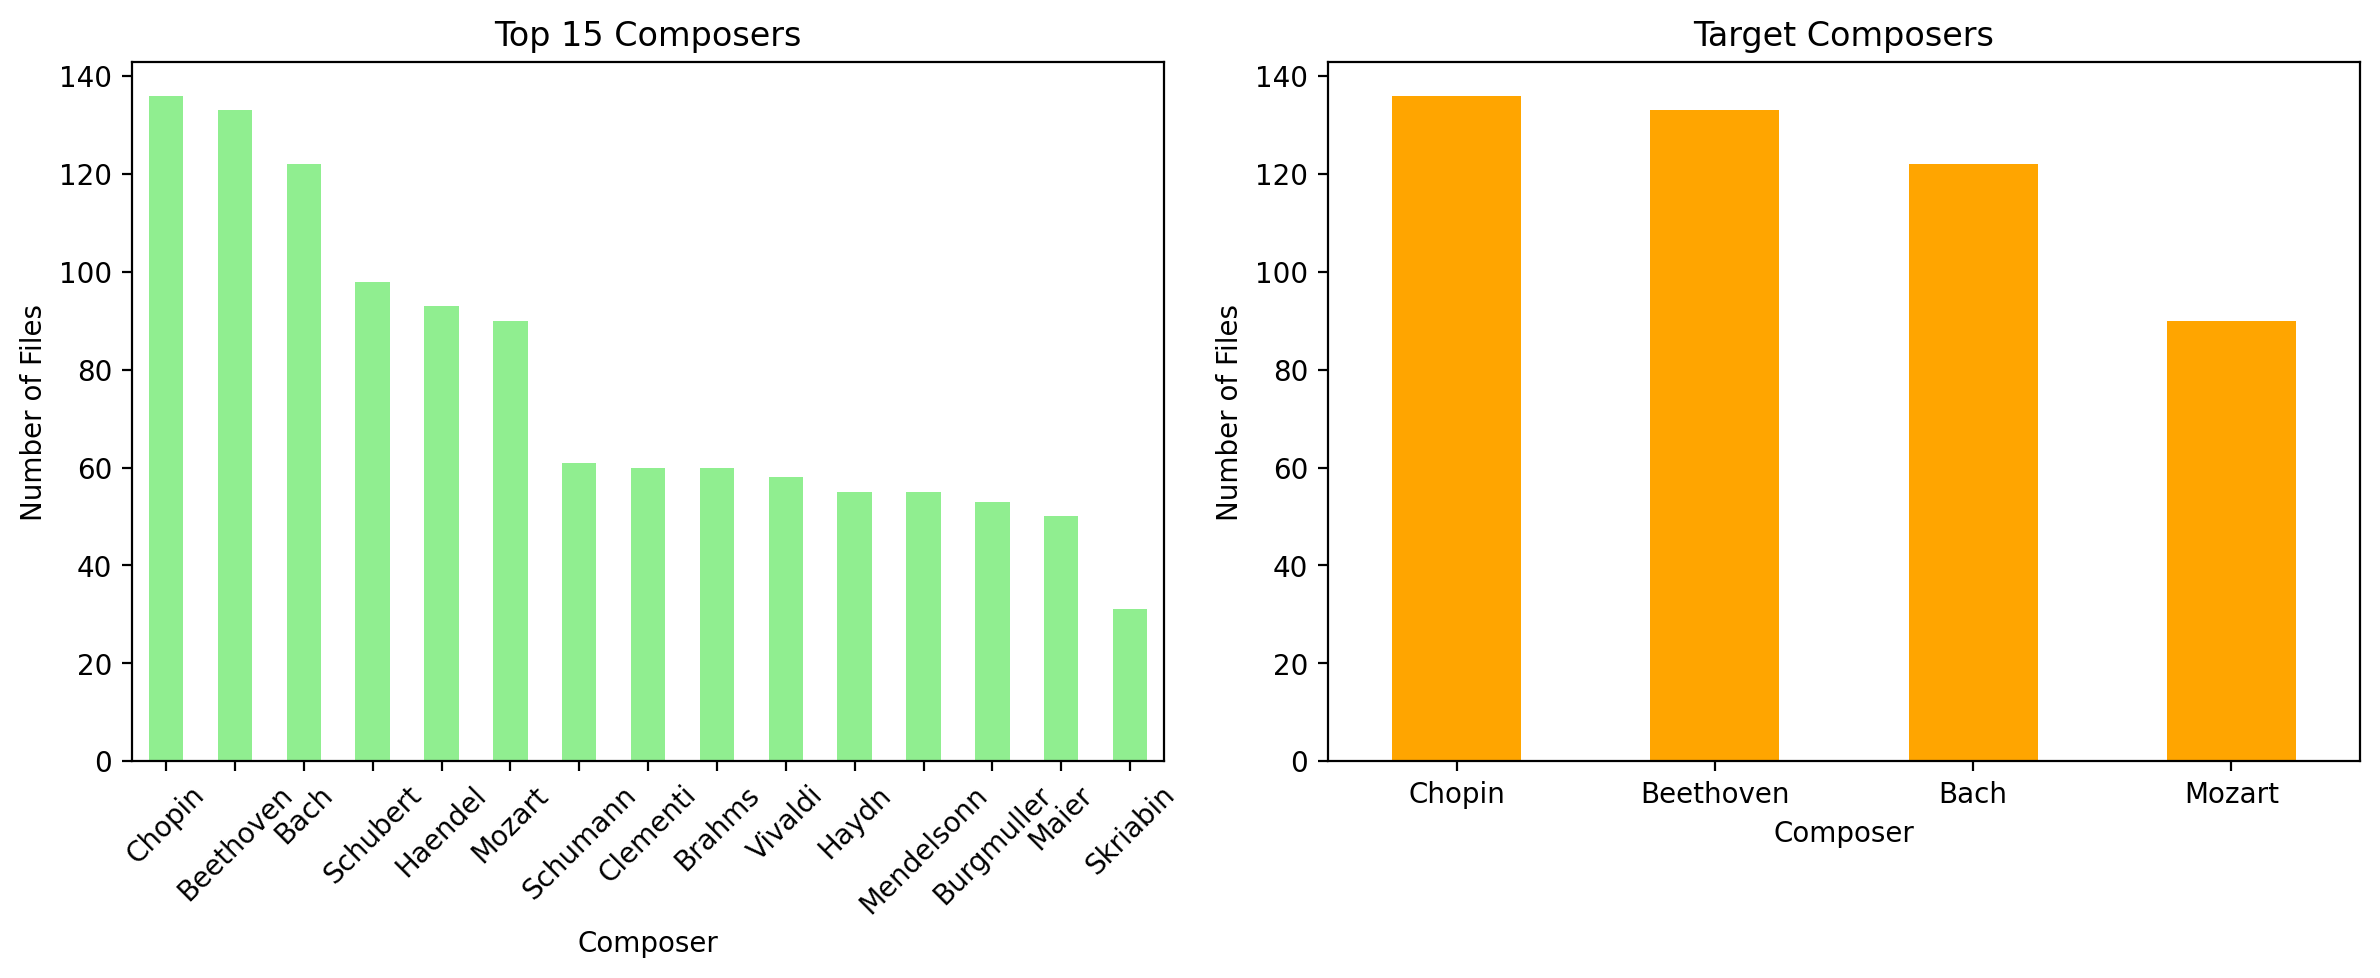

In [5]:
# Initialize MidiProcessor
midi_processor = MidiProcessor()

# Load MIDI file metadata into a DataFrame
all_midi_df = midi_processor.load_midi_files(data_dir)

print(f"Total MIDI files found: {len(all_midi_df)}")

# Filter for required composers only
midi_df = all_midi_df[all_midi_df['composer'].isin(target_composers)].reset_index(drop=True)

print(f"Filtered MIDI files for target composers ({len(target_composers)}): {len(midi_df)}")

# Remove files with missing or invalid paths
midi_df = midi_df[midi_df['file_path'].apply(os.path.exists)].reset_index(drop=True)

# Preprocess MIDI files (clean, deduplicate, filter)
# midi_df = midi_processor.preprocess_midi_files(midi_df)

print(f"Valid MIDI files after preprocessing: {len(midi_df)}")

# Count files for all composers and required composers
all_composer_counts = all_midi_df['composer'].value_counts()
required_composer_counts = midi_df['composer'].value_counts()

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Top 15 composers
top_composers = all_composer_counts.head(15)
top_composers.plot(kind='bar', color='lightgreen', ax=axs[0])
axs[0].set_title('Top 15 Composers')
axs[0].set_xlabel('Composer')
axs[0].set_ylabel('Number of Files')
axs[0].tick_params(axis='x', rotation=45)

# Plot 2: Required composers only
required_composer_counts.plot(kind='bar', color='orange', ax=axs[1])
axs[1].set_title('Target Composers')
axs[1].set_xlabel('Composer')
axs[1].set_ylabel('Number of Files')
axs[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()


<a id='featureextraction'></a>
# 5. Feature Extraction: <a href="#Index" style="font-size:25px;">&#8679;</a>
---

In [6]:
# Extract musical features and notes for each MIDI file and create a new DataFrame
feature_rows = []
total_files = len(midi_df)
for idx, row in midi_df.iterrows():
    percent = ((idx + 1) / total_files) * 100
    print(f"Processing: {percent:.1f}% complete", end='\r')
    features = midi_processor.extract_musical_features(row['file_path'])
    notes = midi_processor.extract_notes_from_midi(row['file_path'])
    features['notes'] = notes
    features['composer'] = row['composer']
    features['filename'] = row['filename']
    feature_rows.append(features)

print("\nExtraction complete.")
features_df = pd.DataFrame(feature_rows)
print(features_df.head())

# Create note sequences for modeling
all_notes_list = features_df['notes'].tolist()
sequence_length = 100
note_sequences, note_to_int, unique_notes = MidiProcessor.create_note_sequences(all_notes_list, sequence_length=sequence_length)
print(f"Total note sequences created: {len(note_sequences)}")

Processing: 100.0% complete
Extraction complete.
   total_notes  total_duration time_signature       key  key_confidence  \
0         4458           927.0            3/4   c minor        0.804161   
1         2122           334.5            3/8   F major        0.944728   
2         3425           804.0            6/8  B- major        0.904651   
3         1388           280.0            4/4   F major        0.849648   
4          926           369.0            3/4  E- major        0.892933   

   tempo  avg_pitch  pitch_range  pitch_std  avg_duration  duration_std  \
0  120.0  61.815331           64  14.624357      0.362625      0.354038   
1   80.0  59.445513           60  14.354830      0.315936      0.152072   
2  144.0  64.324953           58  13.470705      0.449635      0.348676   
3  100.0  62.522913           53  12.018564      0.711996      0.479665   
4  150.0  63.538206           50  12.884719      0.768898      0.536931   

   avg_interval  interval_std instruments  num_pa

<a id='exploratory'></a>
# 6. Exploratory Data Analysis: <a href="#Index" style="font-size:25px;">&#8679;</a>
---

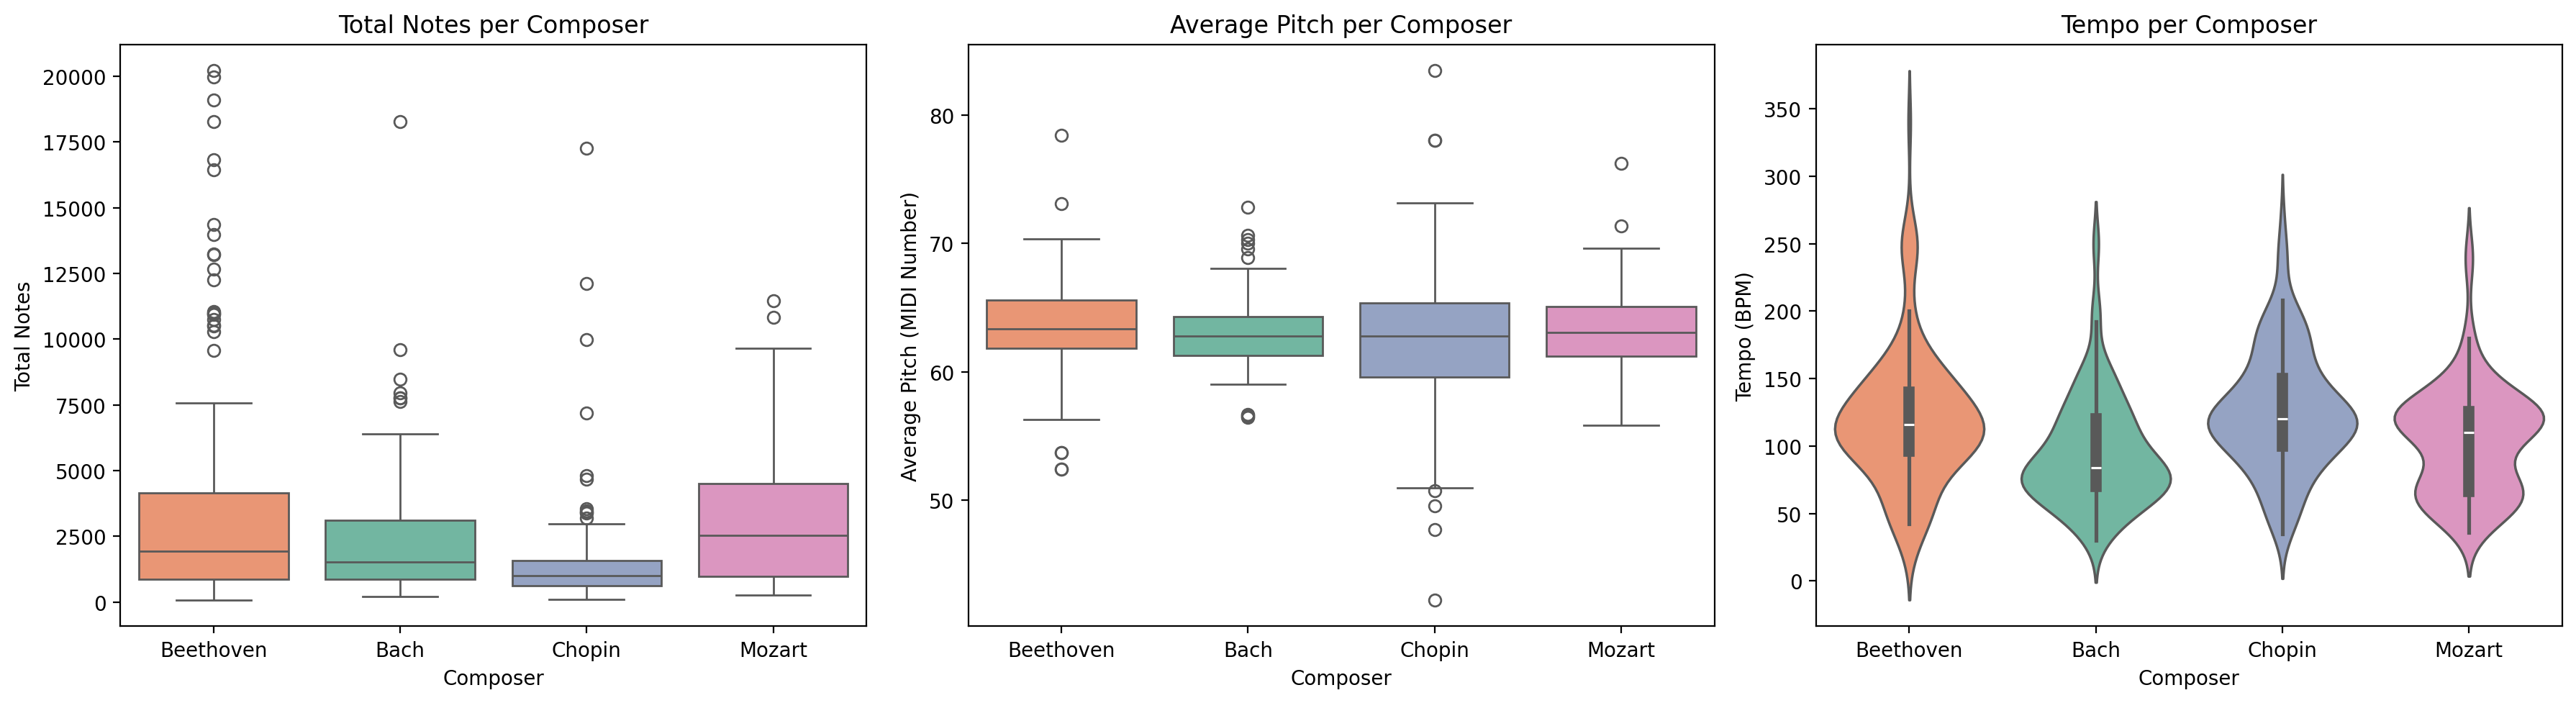

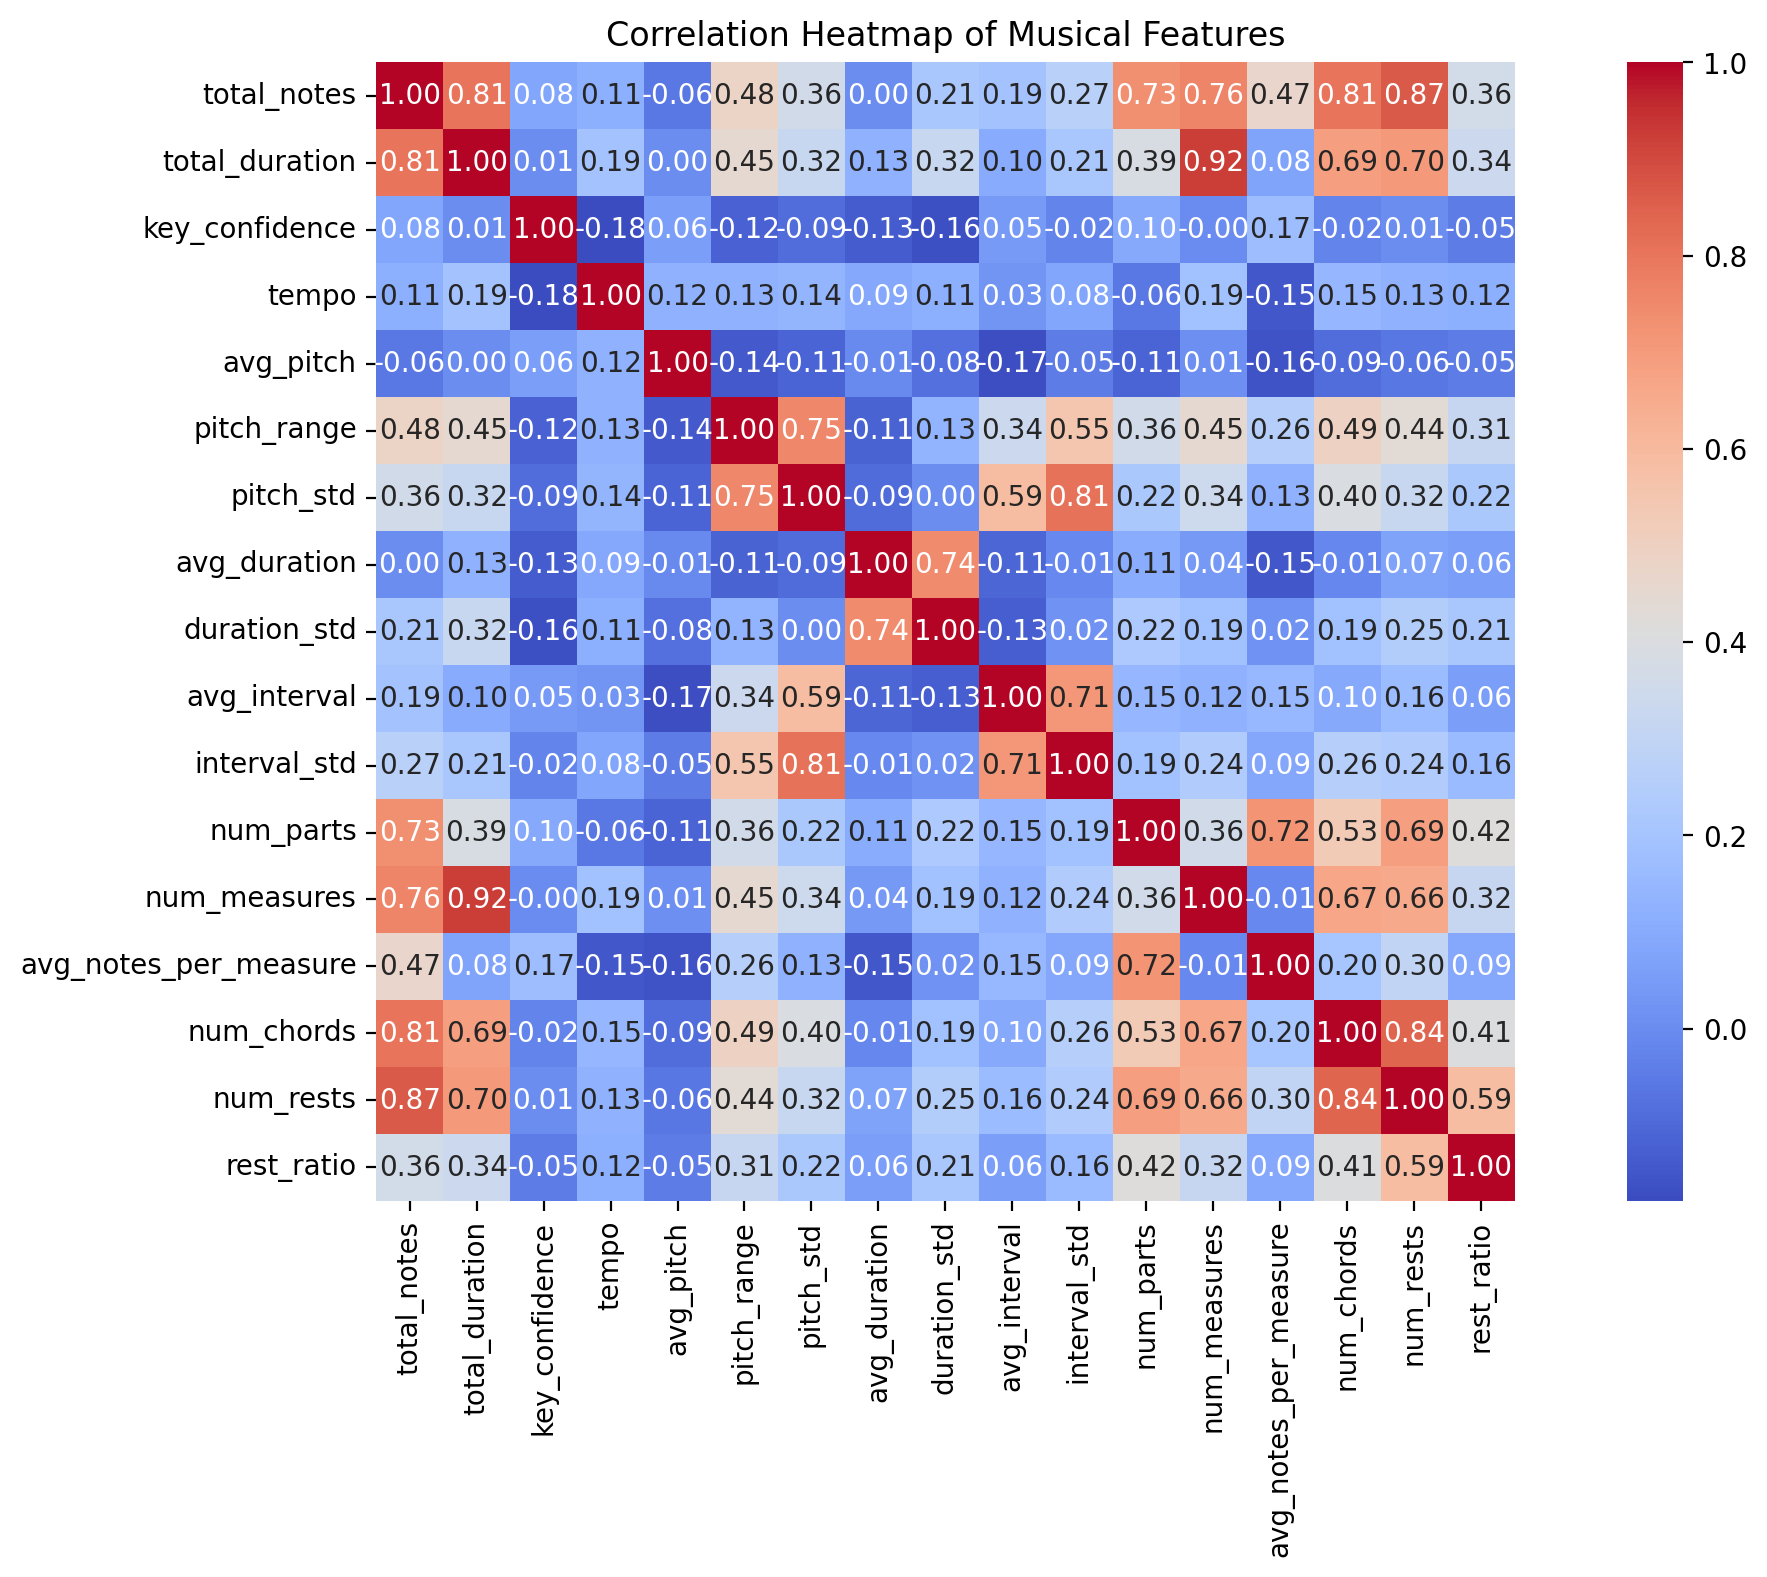

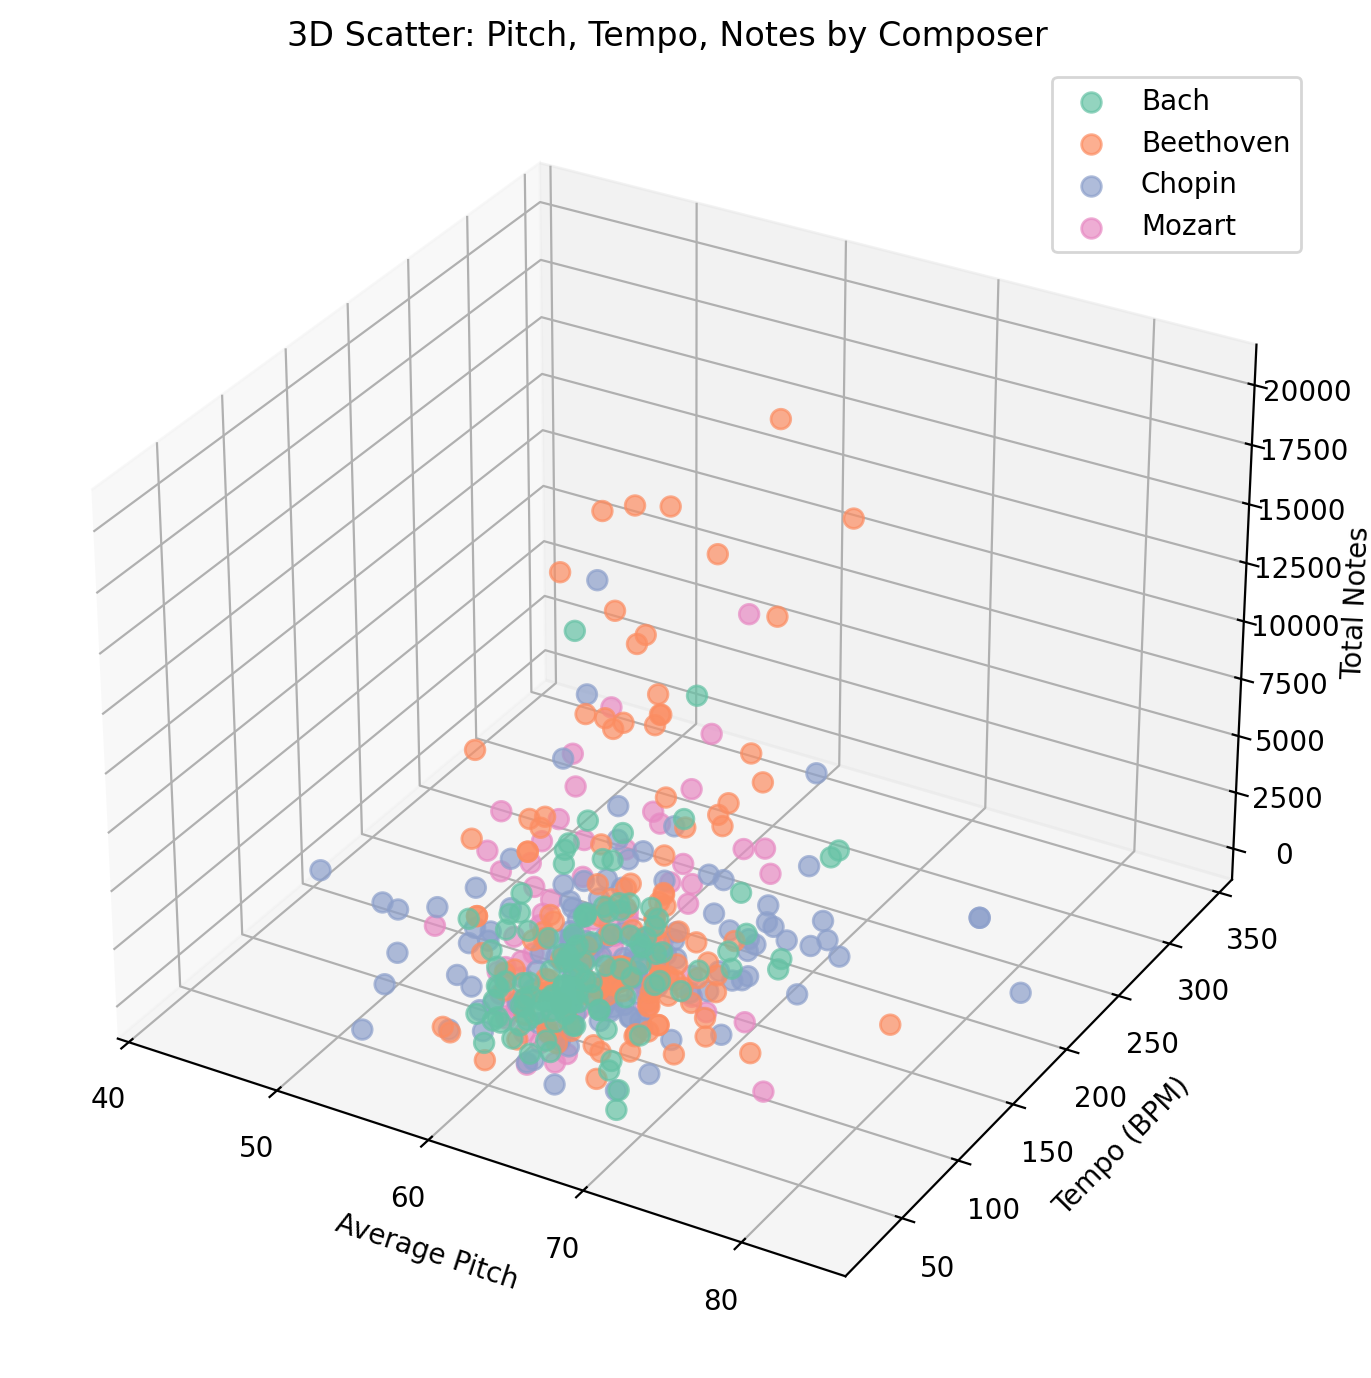

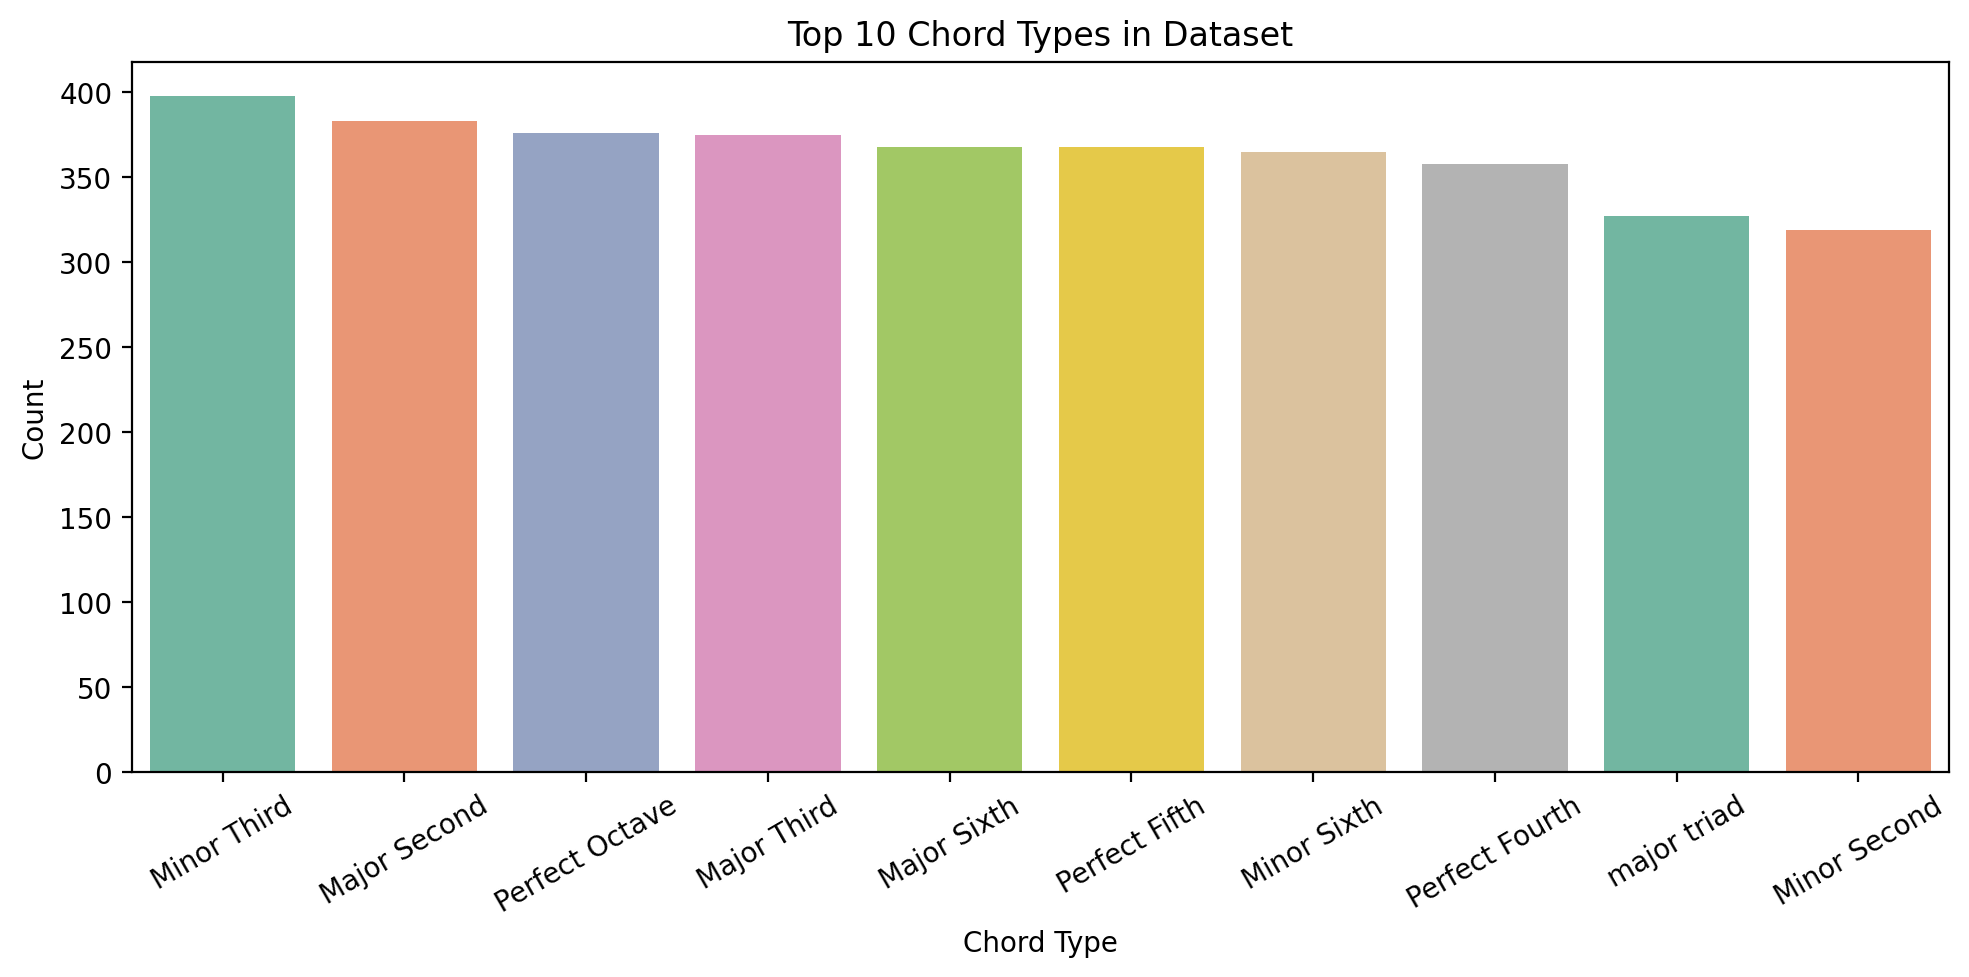

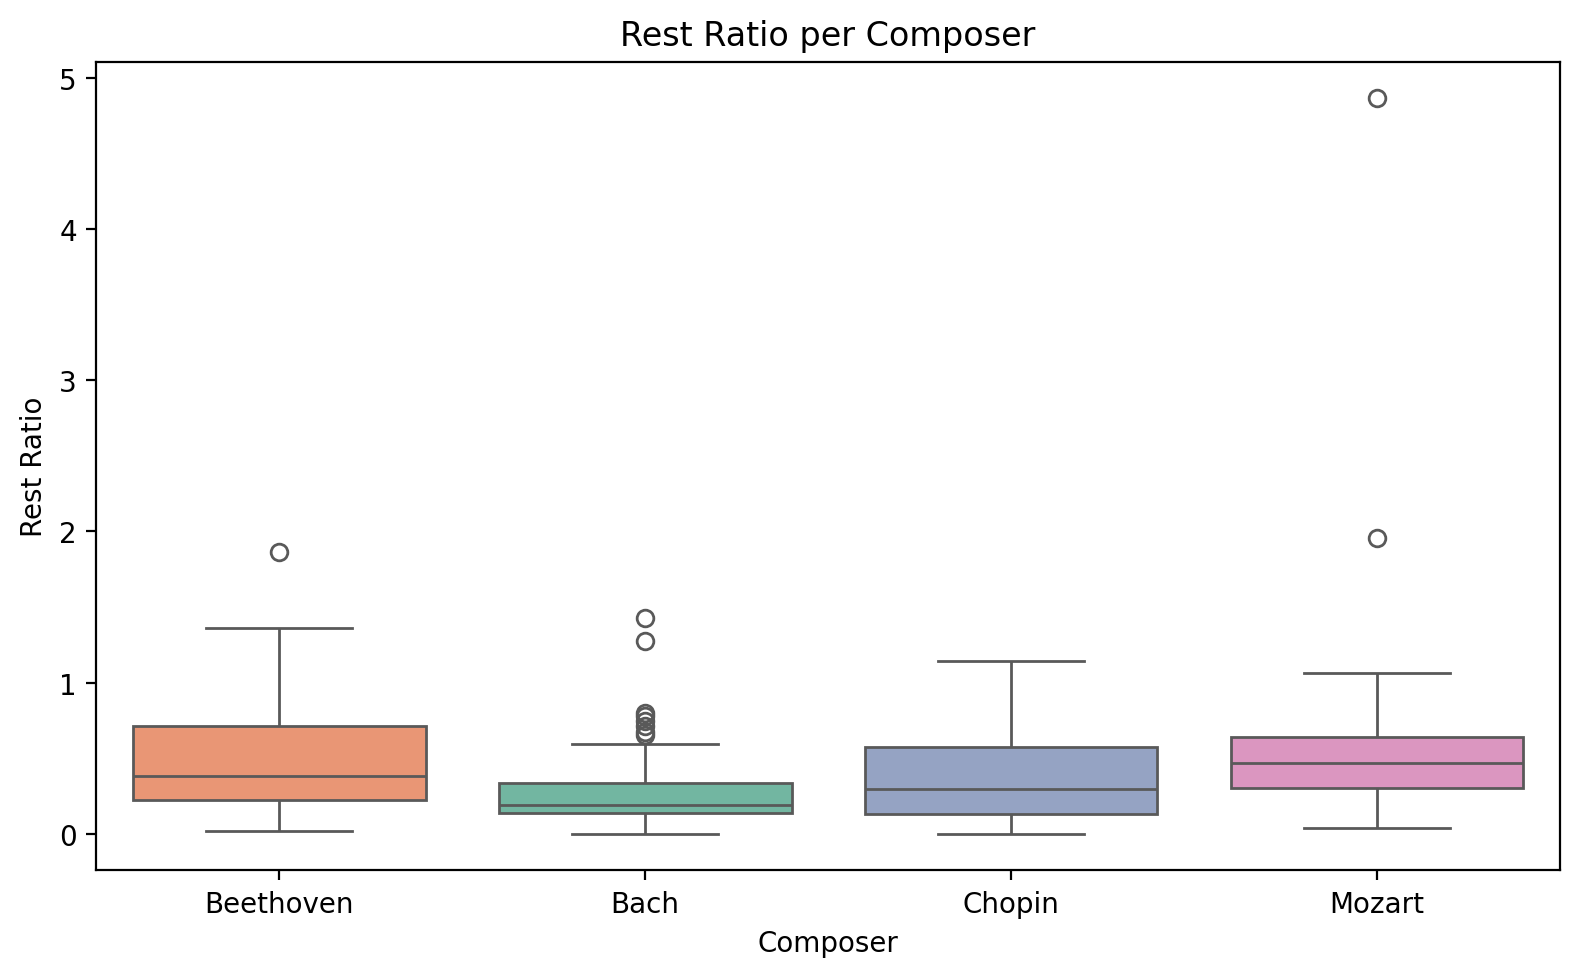

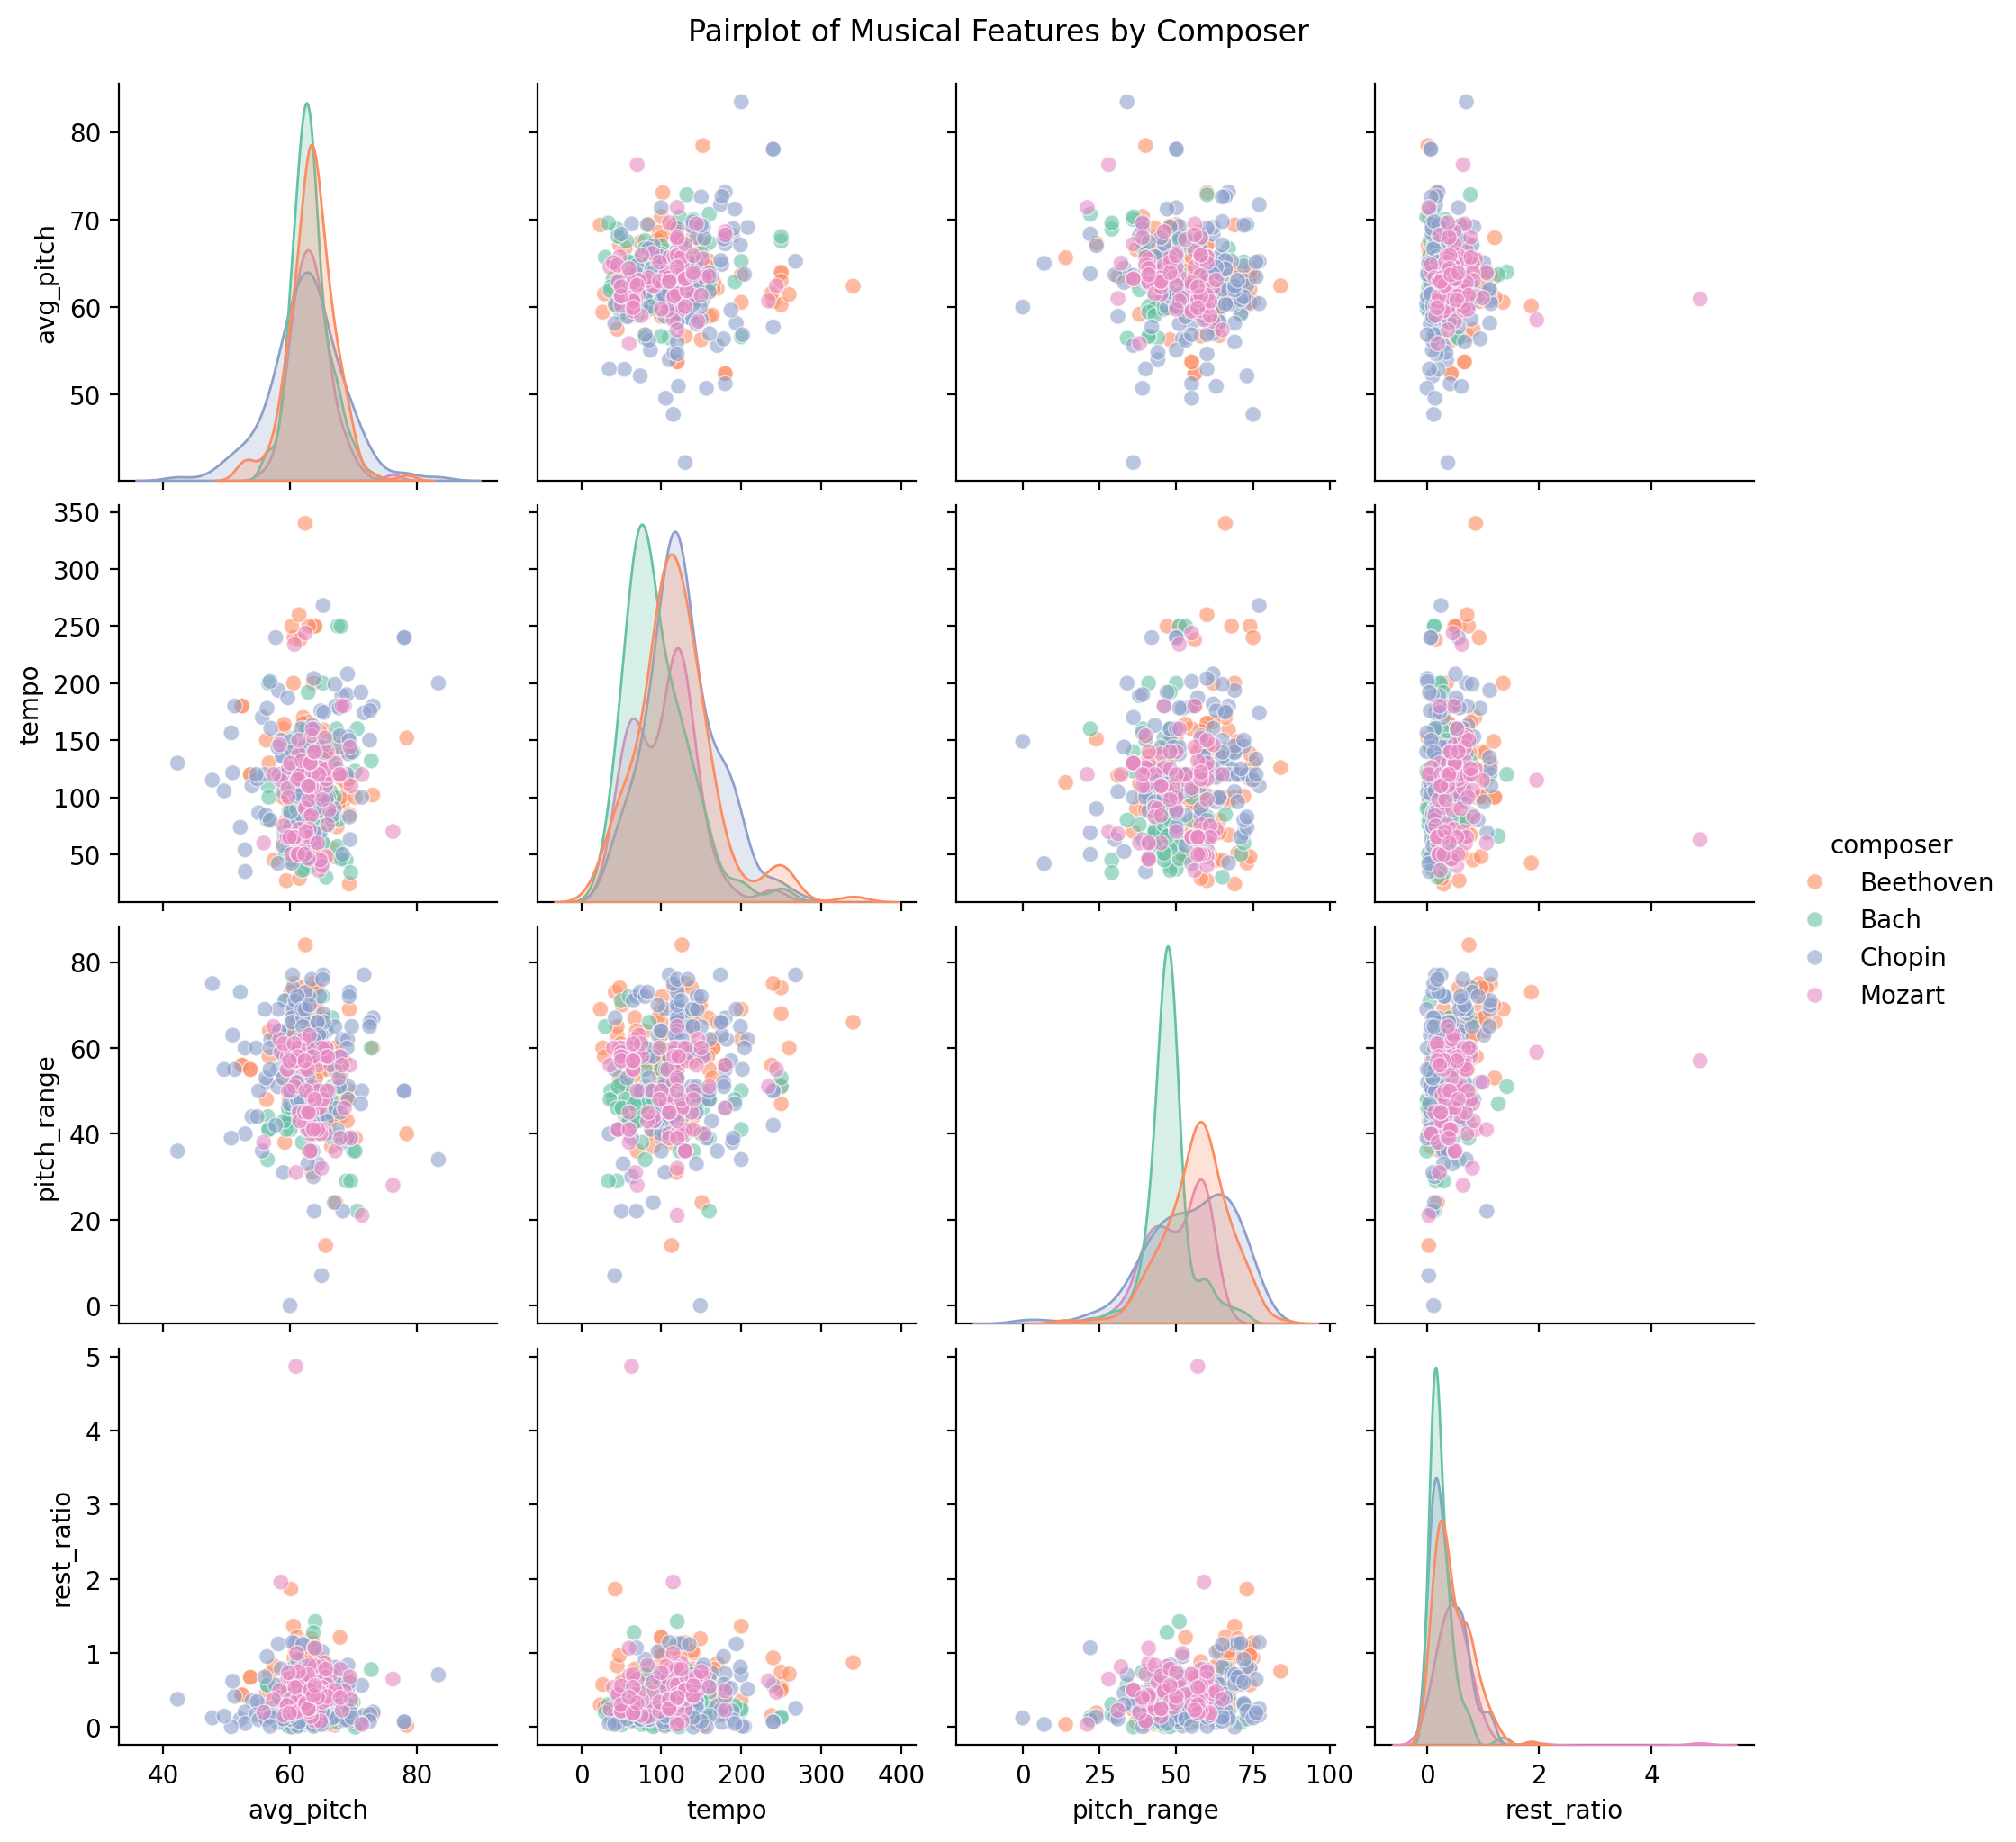

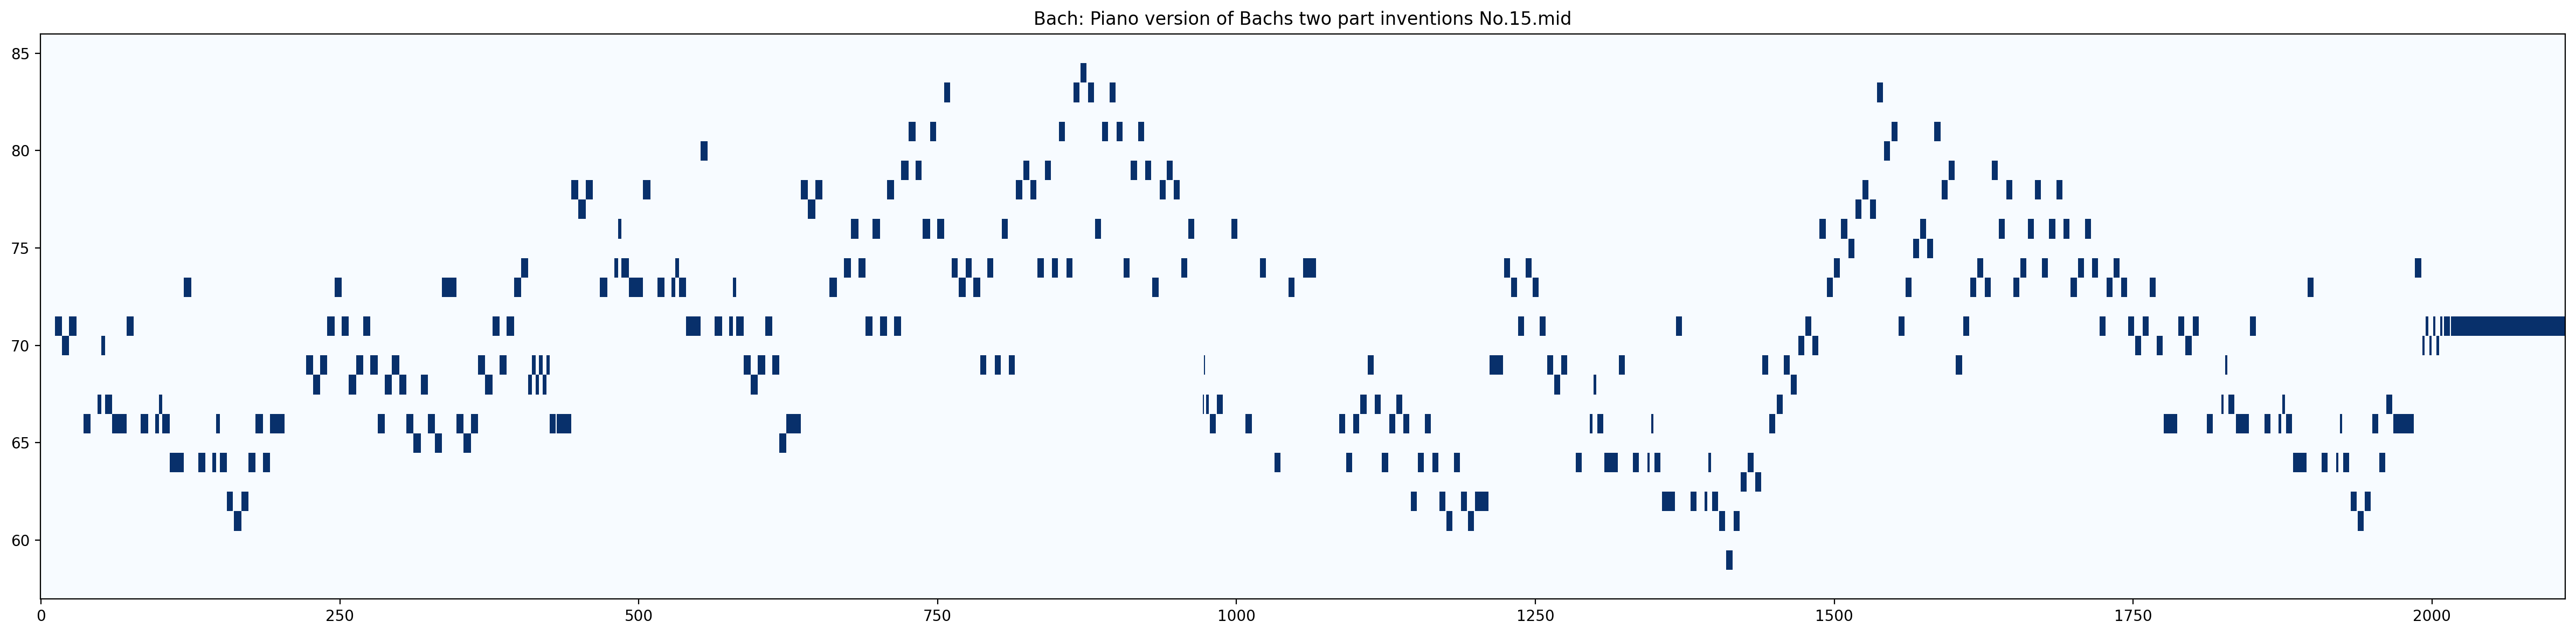

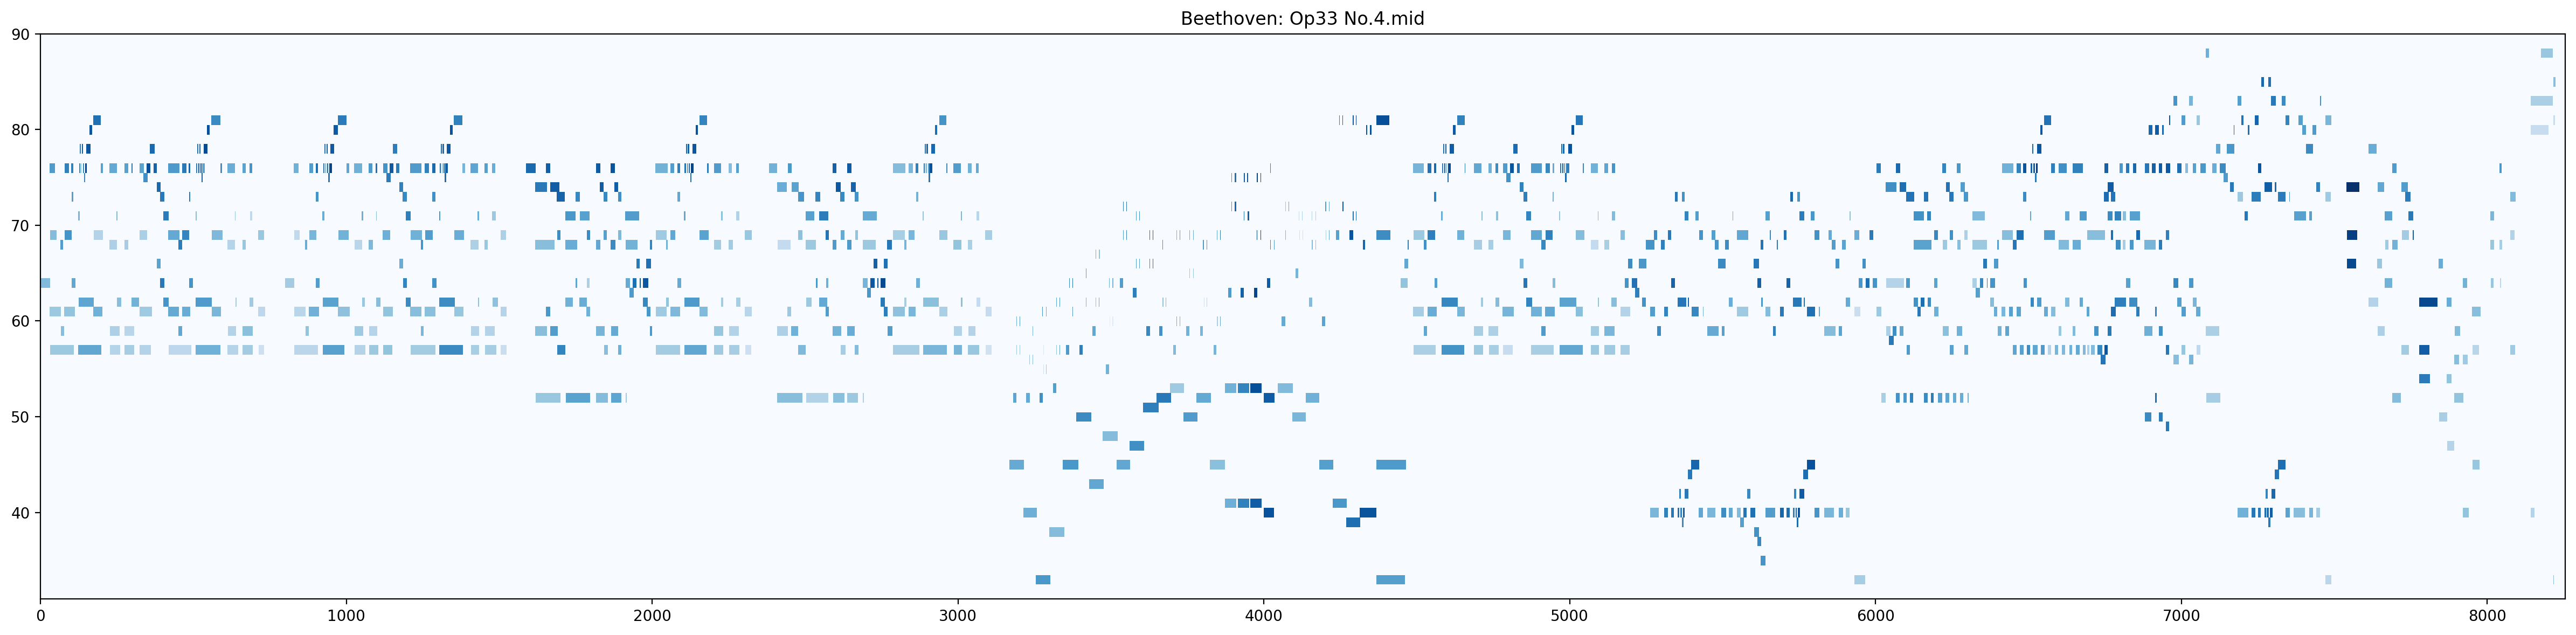

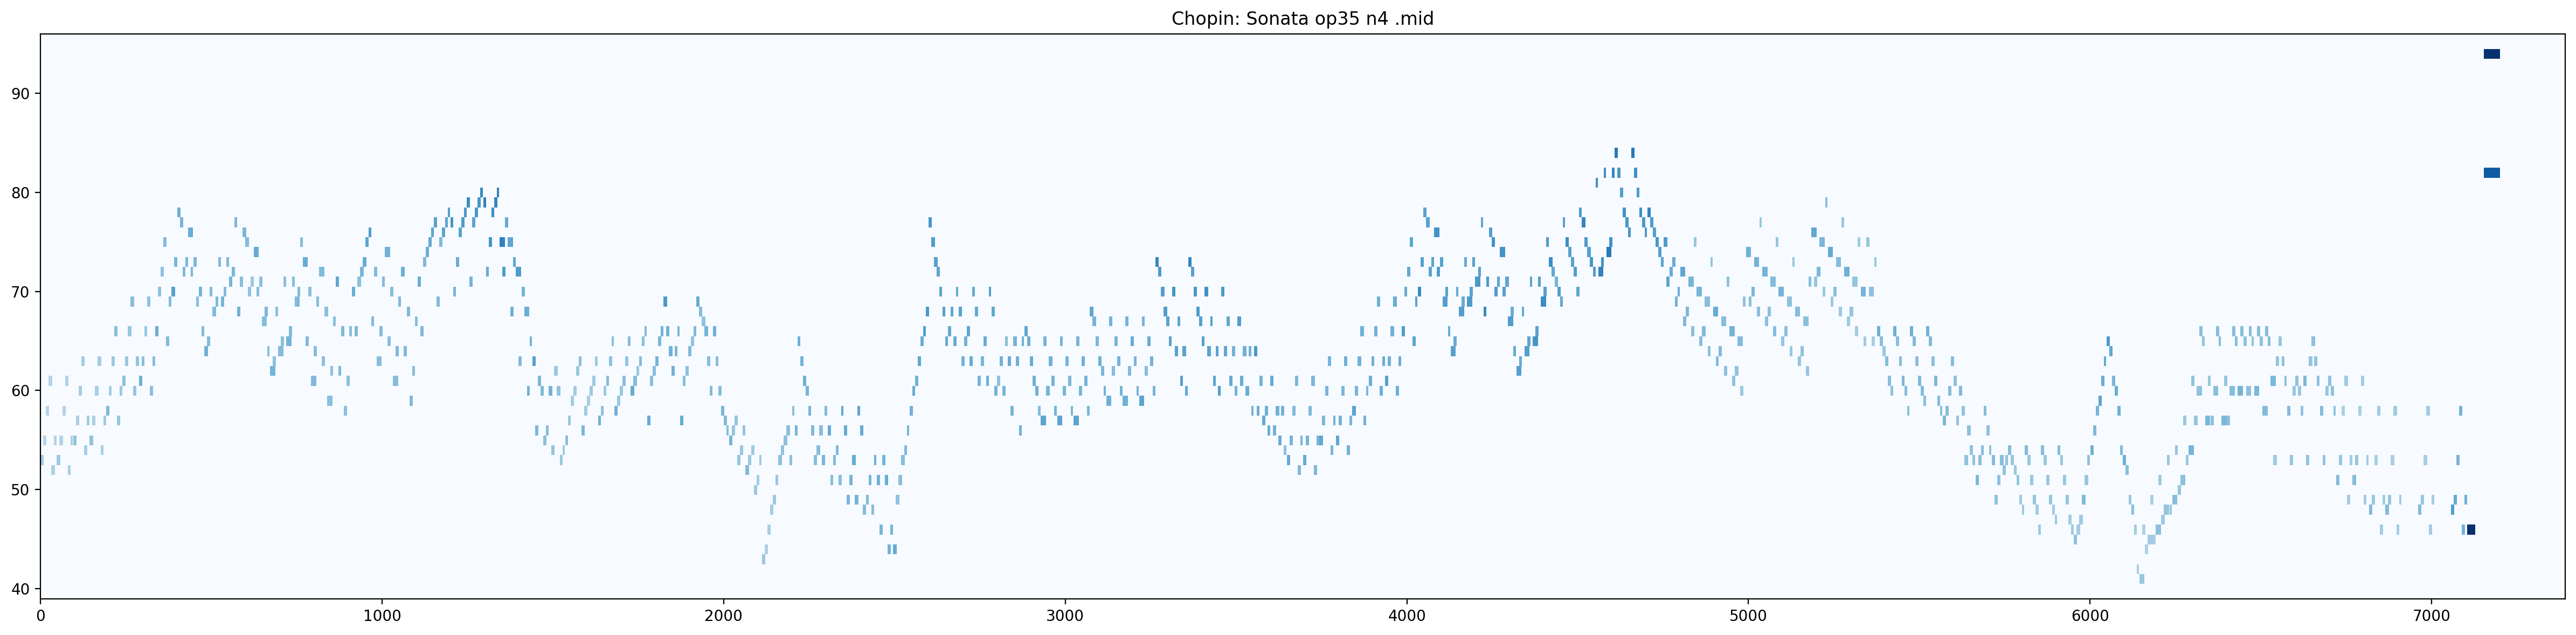

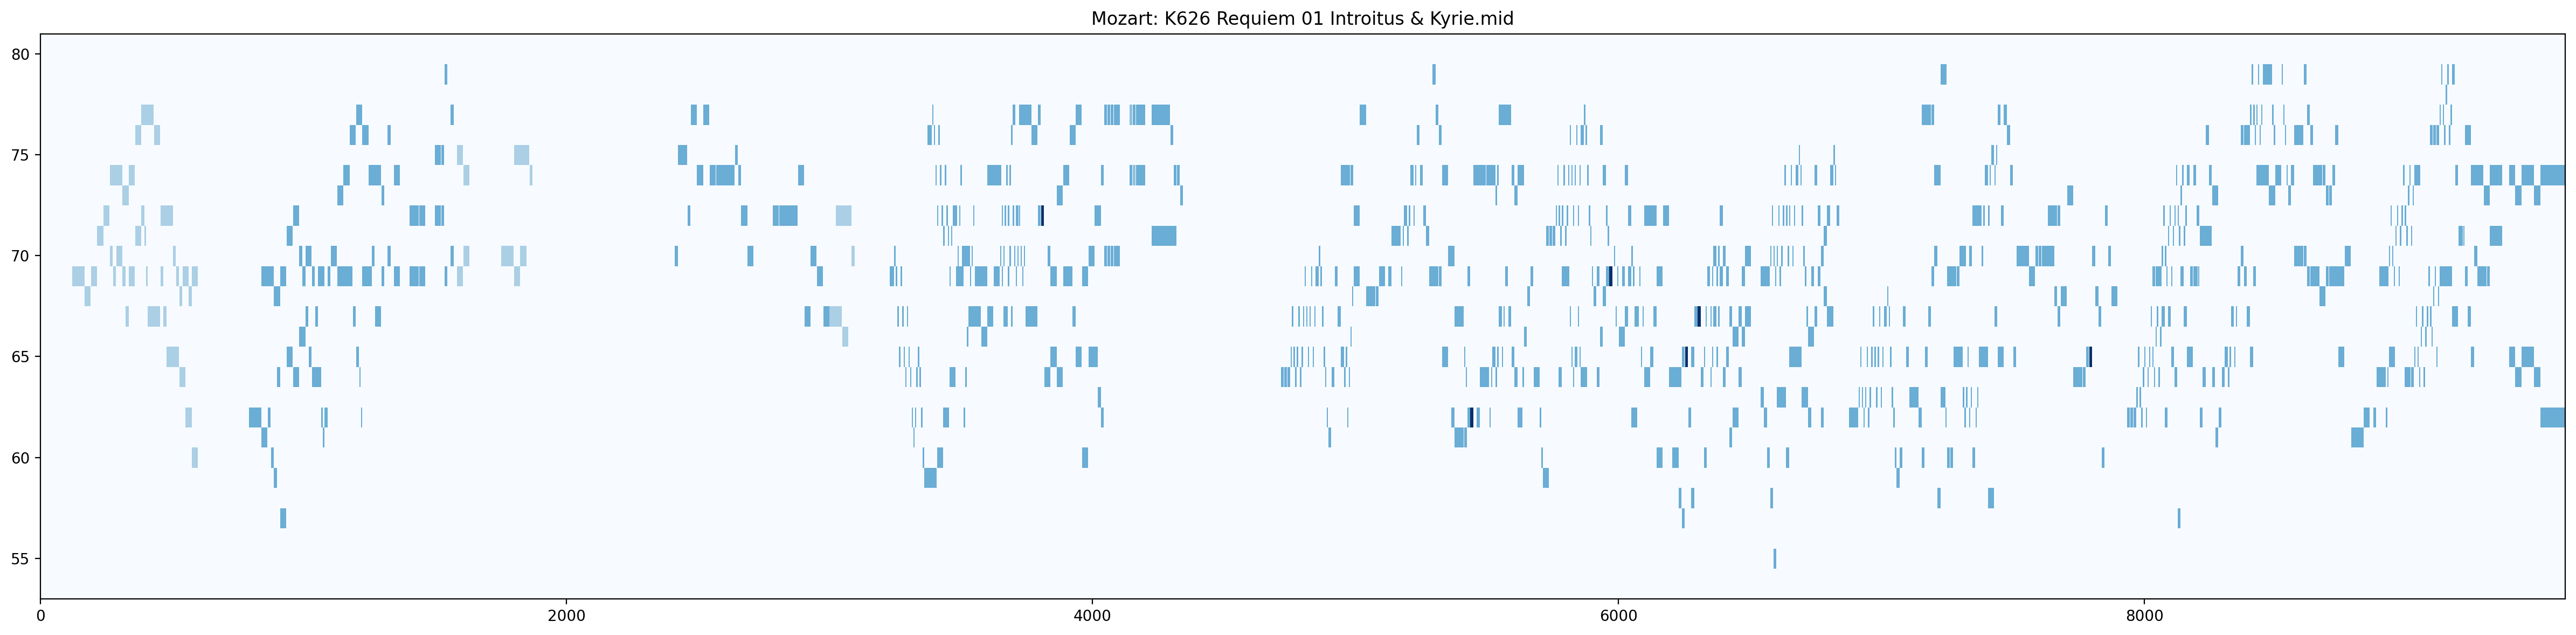

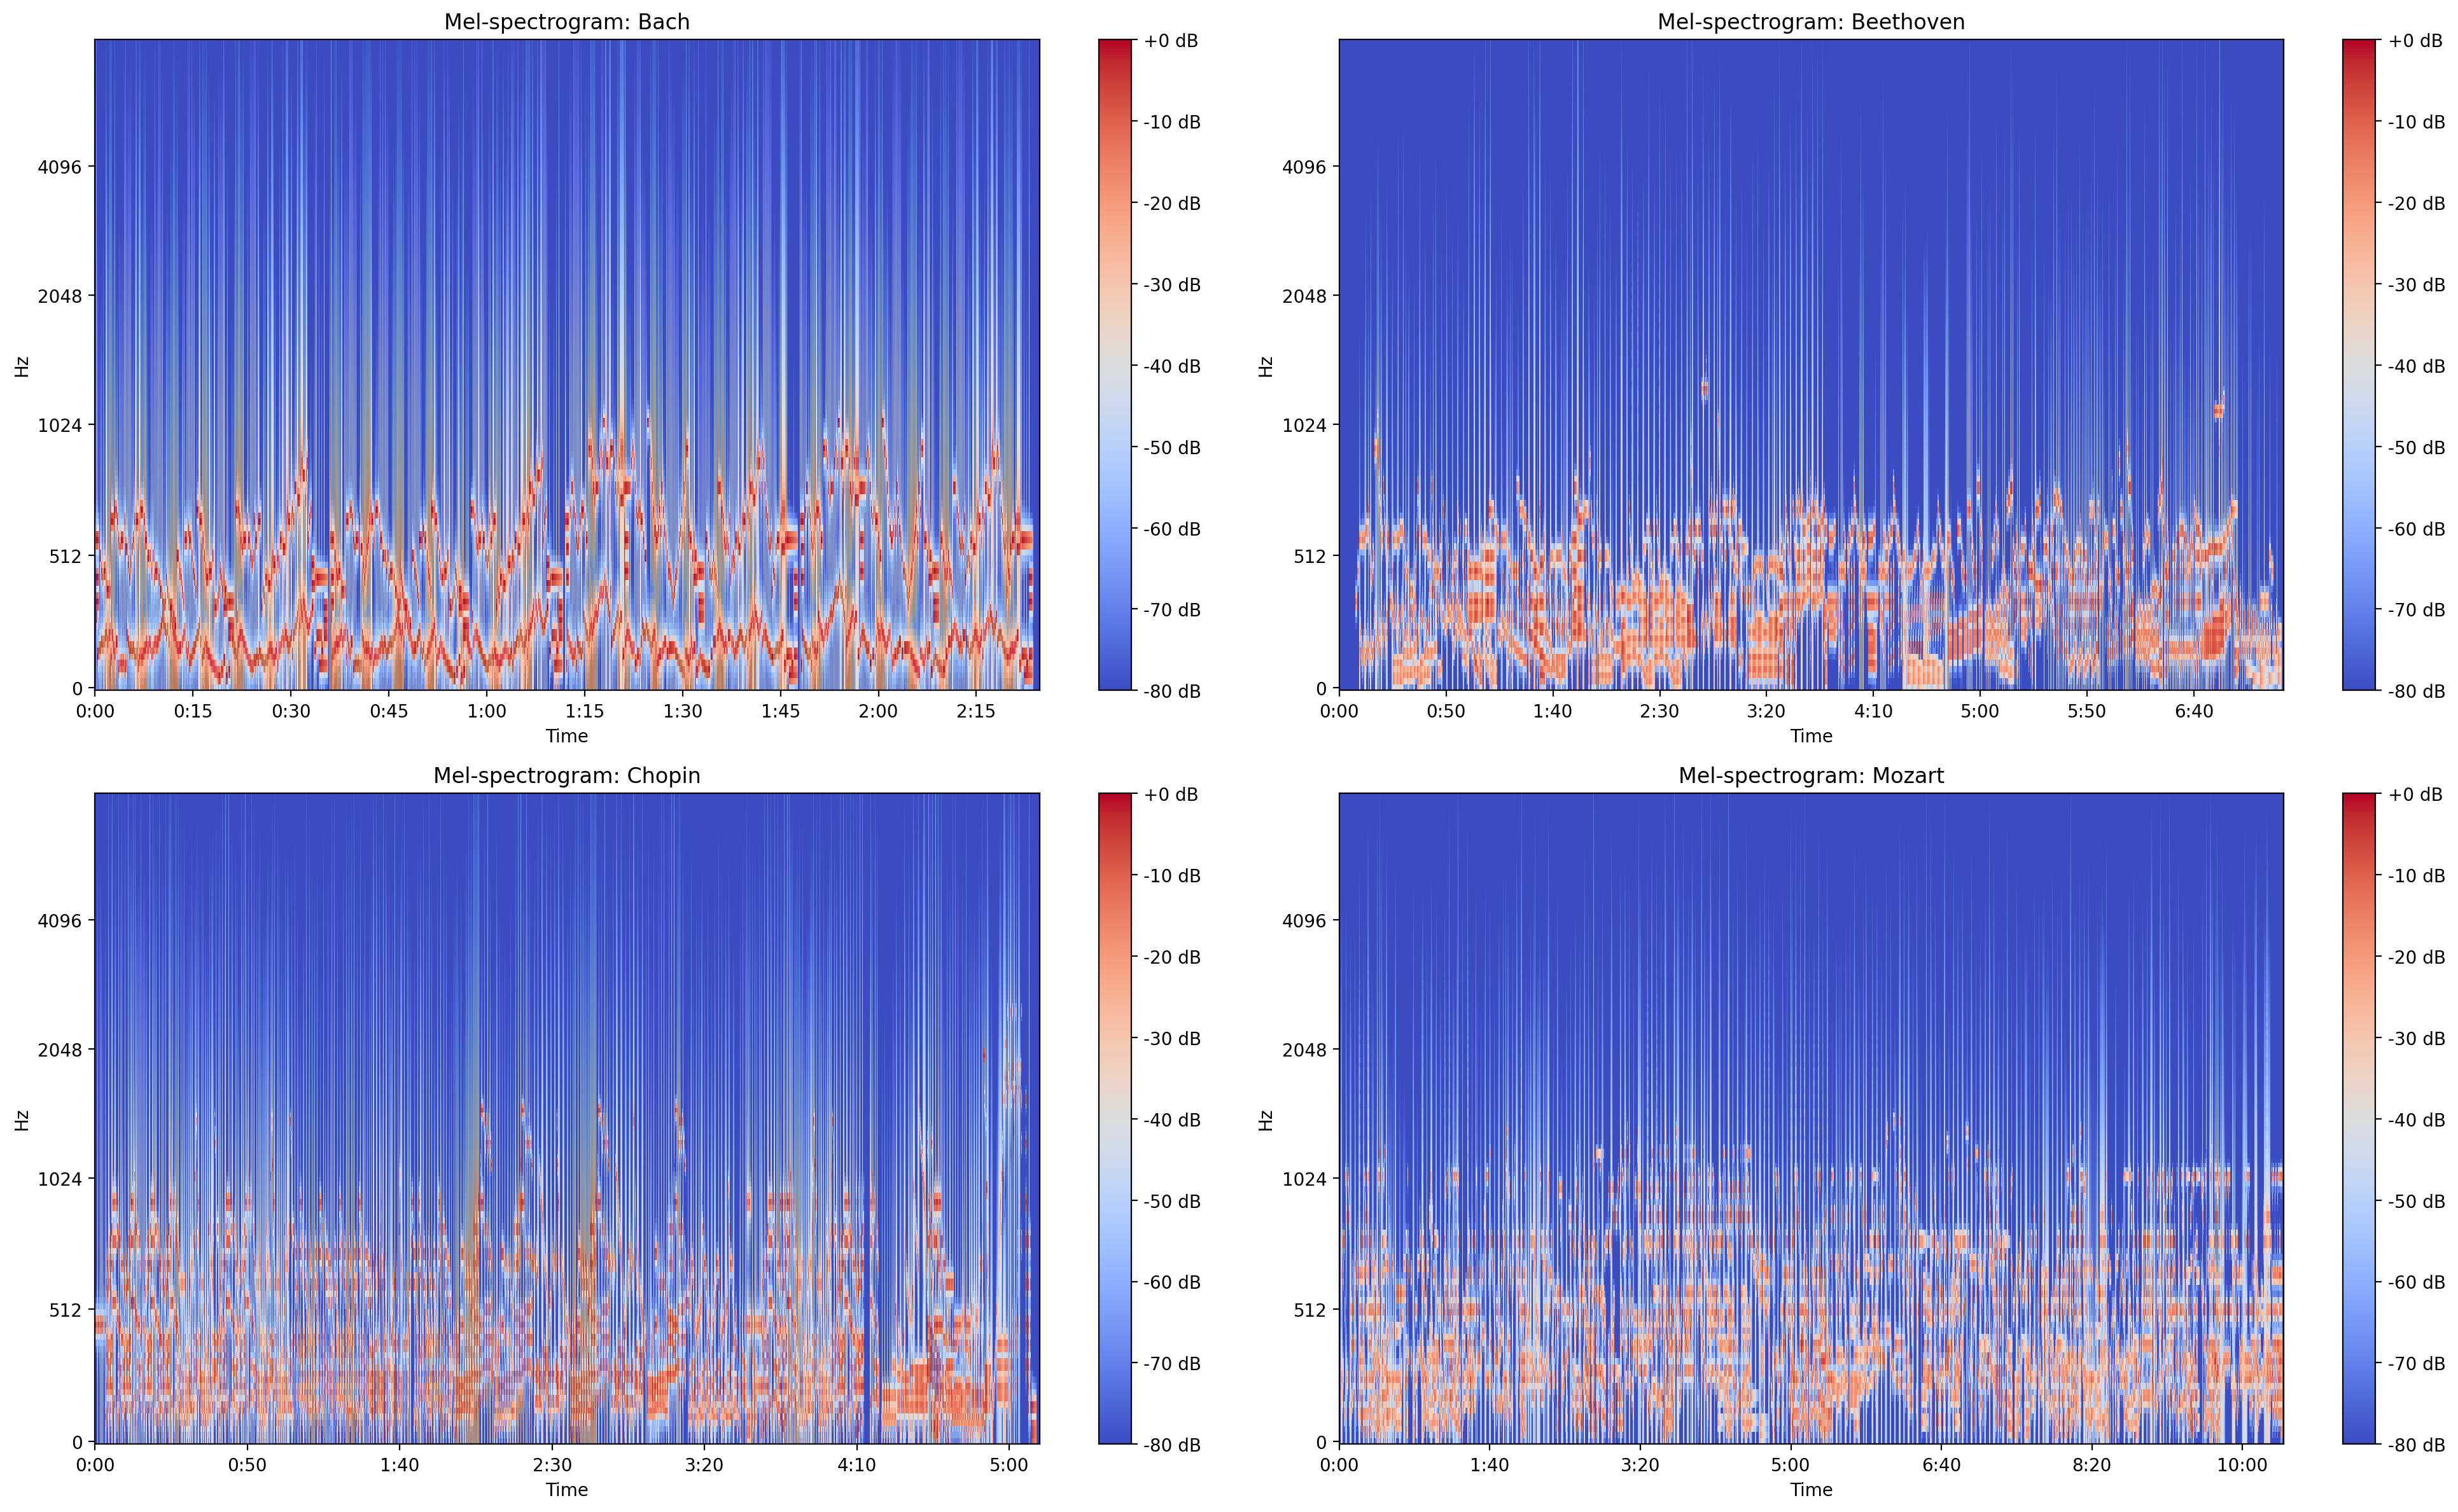

In [55]:
# Create a dictionary for colors and select one sample for each composer
colors = dict(zip(target_composers, sns.color_palette("Set2", len(target_composers))))
sample_indices = []
for composer in target_composers:
    composer_files = midi_df[midi_df['composer'] == composer].index
    sample_indices.append(np.random.choice(composer_files))

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# 1. Distribution of total notes per composer
sns.boxplot(x='composer', y='total_notes', data=features_df, palette=colors, ax=axs[0])
axs[0].set_title('Total Notes per Composer')
axs[0].set_xlabel('Composer')
axs[0].set_ylabel('Total Notes')

# 2. Distribution of average pitch per composer
sns.boxplot(x='composer', y='avg_pitch', data=features_df, palette=colors, ax=axs[1])
axs[1].set_title('Average Pitch per Composer')
axs[1].set_xlabel('Composer')
axs[1].set_ylabel('Average Pitch (MIDI Number)')

# 3. Distribution of tempo per composer
sns.violinplot(x='composer', y='tempo', data=features_df, palette=colors, ax=axs[2])
axs[2].set_title('Tempo per Composer')
axs[2].set_xlabel('Composer')
axs[2].set_ylabel('Tempo (BPM)')

plt.tight_layout()
plt.show()

# 4. Correlation heatmap of numerical features
plt.figure(figsize=(12, 8))
corr = features_df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Musical Features")
plt.tight_layout()
plt.show()

# 5. 3D Scatter plot of average pitch, tempo, and total notes
fig_3d = plt.figure(figsize=(10, 7))
ax = fig_3d.add_subplot(111, projection='3d')
for composer in target_composers:
    subset = features_df[features_df['composer'] == composer]
    ax.scatter(subset['avg_pitch'], subset['tempo'], subset['total_notes'],
              label=composer, alpha=0.7, s=50, color=colors[composer])
ax.set_xlabel('Average Pitch')
ax.set_ylabel('Tempo (BPM)')
ax.set_zlabel('Total Notes')
ax.set_title('3D Scatter: Pitch, Tempo, Notes by Composer')
ax.legend()
plt.tight_layout()
plt.show()

# 6. Top 10 chord types in the dataset
all_chords = [chord for sublist in features_df['chord_types'] for chord in sublist]
top_chords = Counter(all_chords).most_common(10)
chord_names, chord_counts = zip(*top_chords)
plt.figure(figsize=(10, 5))
sns.barplot(x=list(chord_names), y=list(chord_counts), palette="Set2")
plt.title('Top 10 Chord Types in Dataset')
plt.ylabel('Count')
plt.xlabel('Chord Type')
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# 7. Boxplot of rest ratio per composer
plt.figure(figsize=(8, 5))
sns.boxplot(x='composer', y='rest_ratio', data=features_df, palette=colors)
plt.title('Rest Ratio per Composer')
plt.xlabel('Composer')
plt.ylabel('Rest Ratio')
plt.tight_layout()
plt.show()

# 8. Pairplot of selected features colored by composer
sns.pairplot(features_df, vars=['avg_pitch', 'tempo', 'pitch_range', 'rest_ratio'],
             hue='composer', palette=colors, diag_kind='kde', plot_kws={'alpha':0.6, 's':40})
plt.suptitle('Pairplot of Musical Features by Composer', y=1.02)
plt.show()

# 9. Plotting MIDI files for each composer
for i, idx in enumerate(sample_indices):
    sample_path = midi_df.loc[idx, 'file_path']
    multitrack = pypianoroll.read(sample_path)
    pr = multitrack.tracks[0].pianoroll
    pitch_sum = pr.sum(axis=0)
    nonzero_pitches = np.where(pitch_sum > 0)[0]
    if len(nonzero_pitches) > 0:
        min_pitch = max(nonzero_pitches[0] - 2, 0)
        max_pitch = min(nonzero_pitches[-1] + 2, 127)
    else:
        min_pitch, max_pitch = 21, 108
    fig = plt.figure(figsize=(24, 6))
    ax = fig.add_subplot(111)
    ax.imshow(
        multitrack.tracks[0].pianoroll.T,
        aspect='auto',
        origin='lower',
        interpolation='nearest',
        cmap='Blues'
    )
    ax.set_ylim(min_pitch, max_pitch)
    plt.title(f"{target_composers[i]}: {midi_df.loc[idx, 'filename']}")
    plt.tight_layout()
    plt.show()

# 10. Mel-spectrograms for each composer
plt.figure(figsize=(20, 12))
for i, composer in enumerate(target_composers, 1):
    composer_files = midi_df[midi_df['composer'] == composer]['file_path'].values
    sample_file = np.random.choice(composer_files)
    pm = pretty_midi.PrettyMIDI(sample_file)
    audio_data = pm.synthesize(fs=22050)
    
    plt.subplot(2, 2, i)
    mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=22050, n_mels=128, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    librosa.display.specshow(mel_spec_db, y_axis='mel', x_axis='time', fmax=8000, cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Mel-spectrogram: {composer}')

plt.tight_layout()
plt.show()


<a id='modelbuilding'></a>
# 7. Model Building: <a href="#Index" style="font-size:25px;">&#8679;</a>
---

<a id='modelbuildinglstm'></a>
## 7.1 Long Short-Term Memory (LSTM): <a href="#Index" style="font-size:25px;">&#8679;</a>
---

<a id='modelselectioncnn'></a>
## 7.2 Convolutional Neural Network (CNN): <a href="#Index" style="font-size:25px;">&#8679;</a>
---

<a id='modeltraining'></a>
# 8. Model Training: <a href="#Index" style="font-size:25px;">&#8679;</a>
---

<a id='modelevaluation'></a>
# 9. Model Evaluation: <a href="#Index" style="font-size:25px;">&#8679;</a>
---

<a id='modeloptimiztion'></a>
# 10. Model Optimization: <a href="#Index" style="font-size:25px;">&#8679;</a>
---

<a id='deployment'></a>
# 11. Deployment: <a href="#Index" style="font-size:25px;">&#8679;</a>
---

<a id='conclusion'></a>
# 12. Conclusion: <a href="#Index" style="font-size:25px;">&#8679;</a>
---

<a id='recommendations'></a>
# 13. Recommendations: <a href="#Index" style="font-size:25px;">&#8679;</a>
---

<a id='nextsteps'></a>
# 14. Next Steps: <a href="#Index" style="font-size:25px;">&#8679;</a>
---

<a id='references'></a>
# 15. References: <a href="#Index" style="font-size:25px;">&#8679;</a>
---